# Transaction cost analysis

Investors should not ignore the impact of STT (Securities Transaction Tax) on investment strategies. As inflation rates come down, notional rates of returns are going to compress. However, STT remains at 0.1% of notional traded value. Here's one way to think through the impact of portfolio turnover on returns.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=99999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(ggrepel)
library(reshape2)

library(quantmod)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
indices <- Indices()

## What is the "average" annual returns of NIFTY 50 TR?

Historical notional returns of the NIFTY 50 are contaminated by high inflation rates. Annualized [inflation adjusted returns](inflation-adjusted-returns.R.ipynb) over different 10-year periods are, on average, 6-6.5%. If you assume an inflation rate of 4%, 10-year notional returns should be in the 10-10.5% range.

## What is the return differential between market-cap weight and equal weight Nifty?

In [2]:
indexName <- "NIFTY 50 TR"

nifty <- indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

mktcapXts <- xts(nifty$CLOSE, nifty$TIME_STAMP)

In [3]:
indexName <- "NIFTY50 EQUAL WEIGHT TR"
niftyEql <- indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

eqWtXts <- xts(niftyEql$CLOSE, niftyEql$TIME_STAMP)

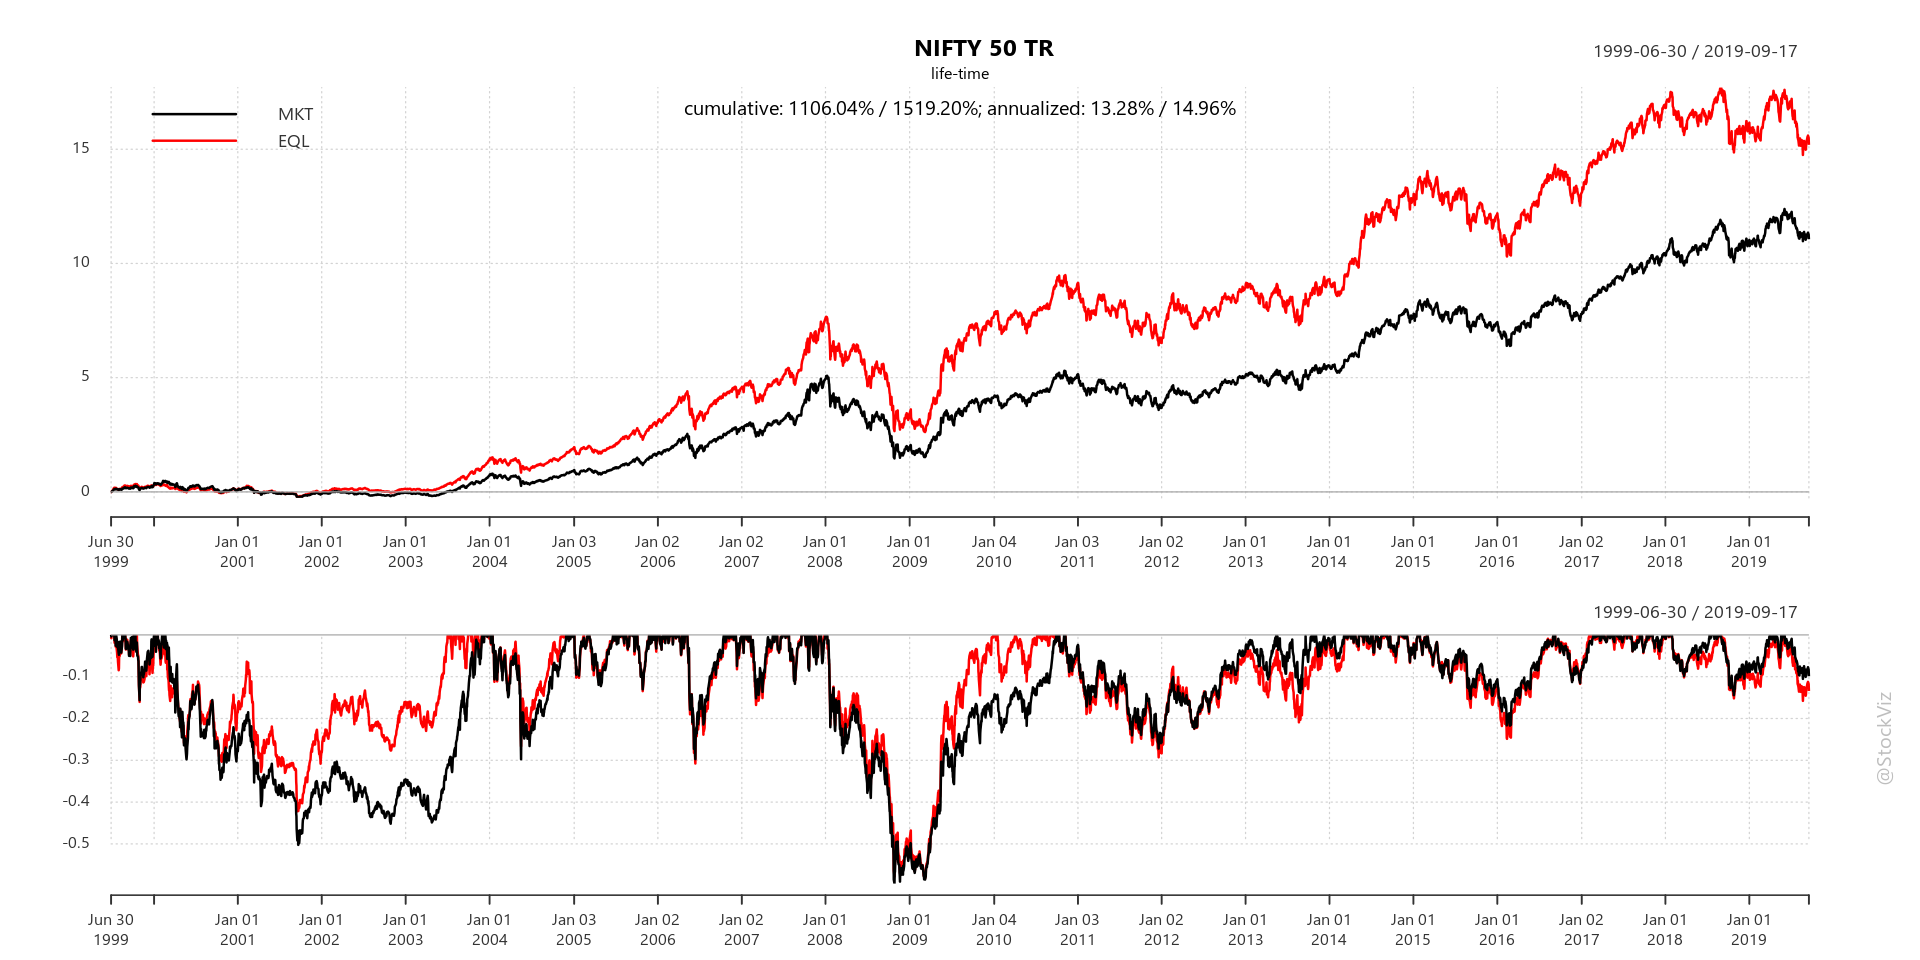

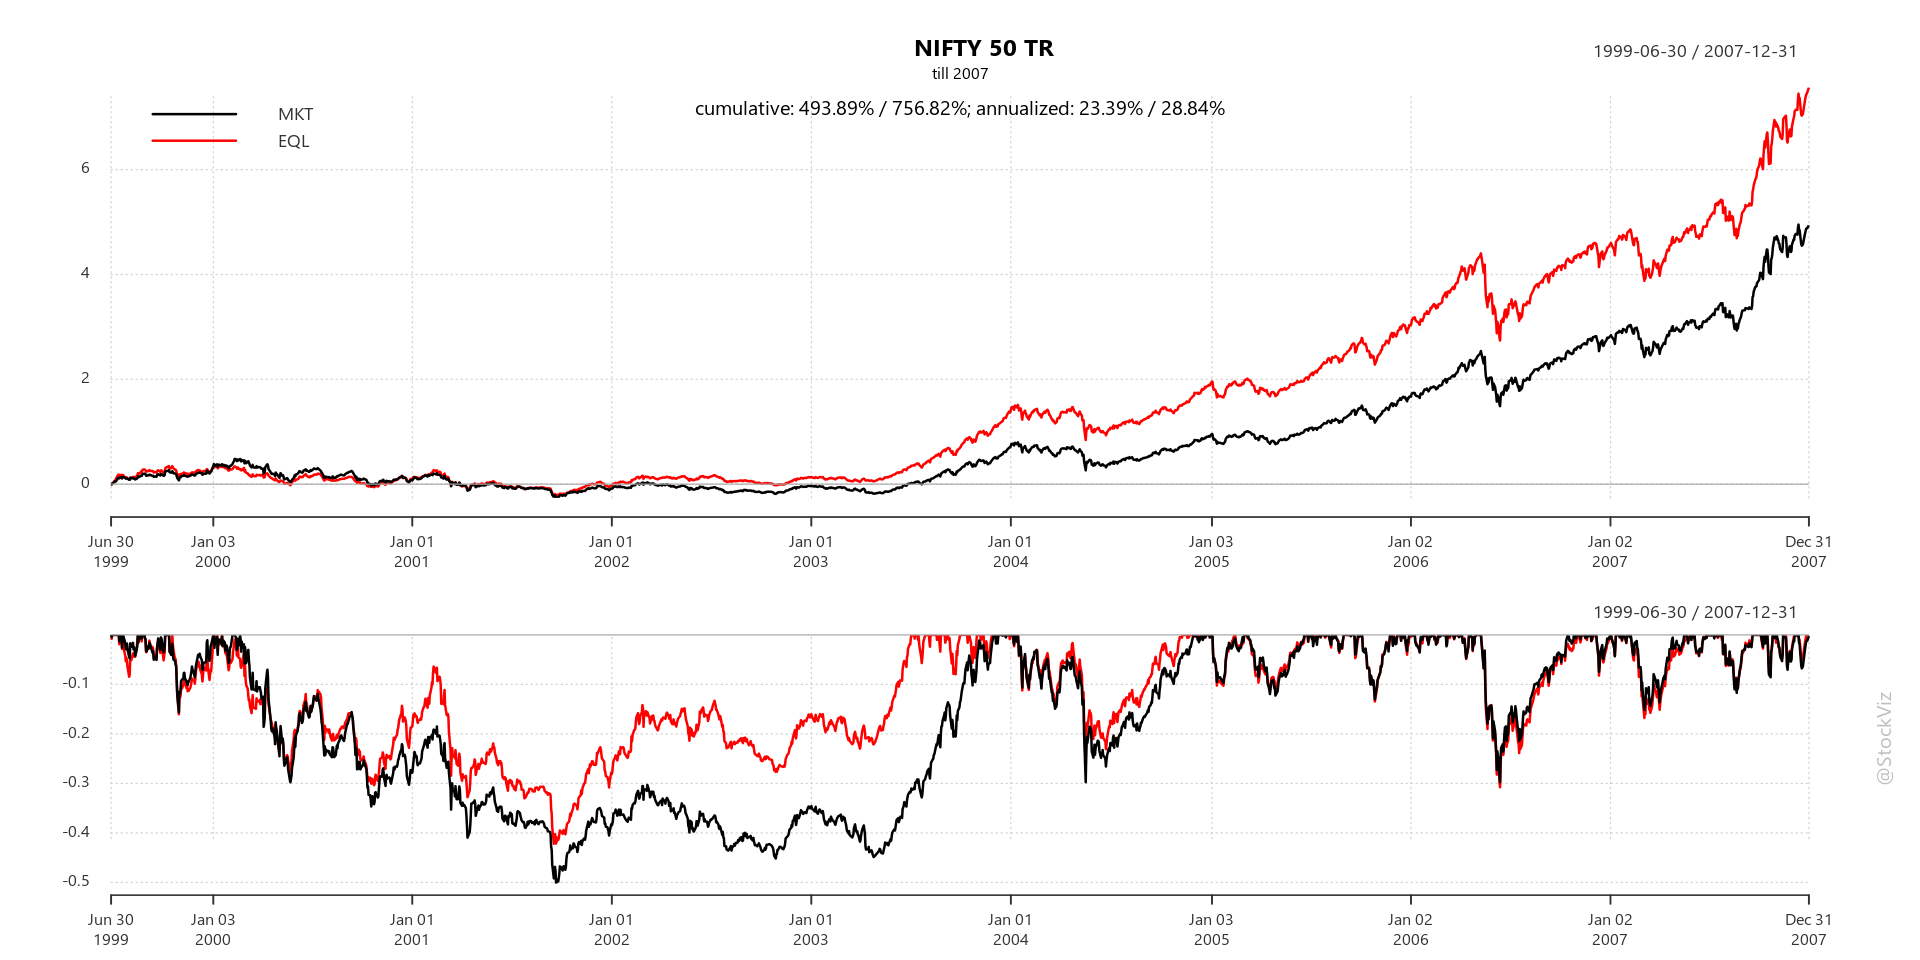

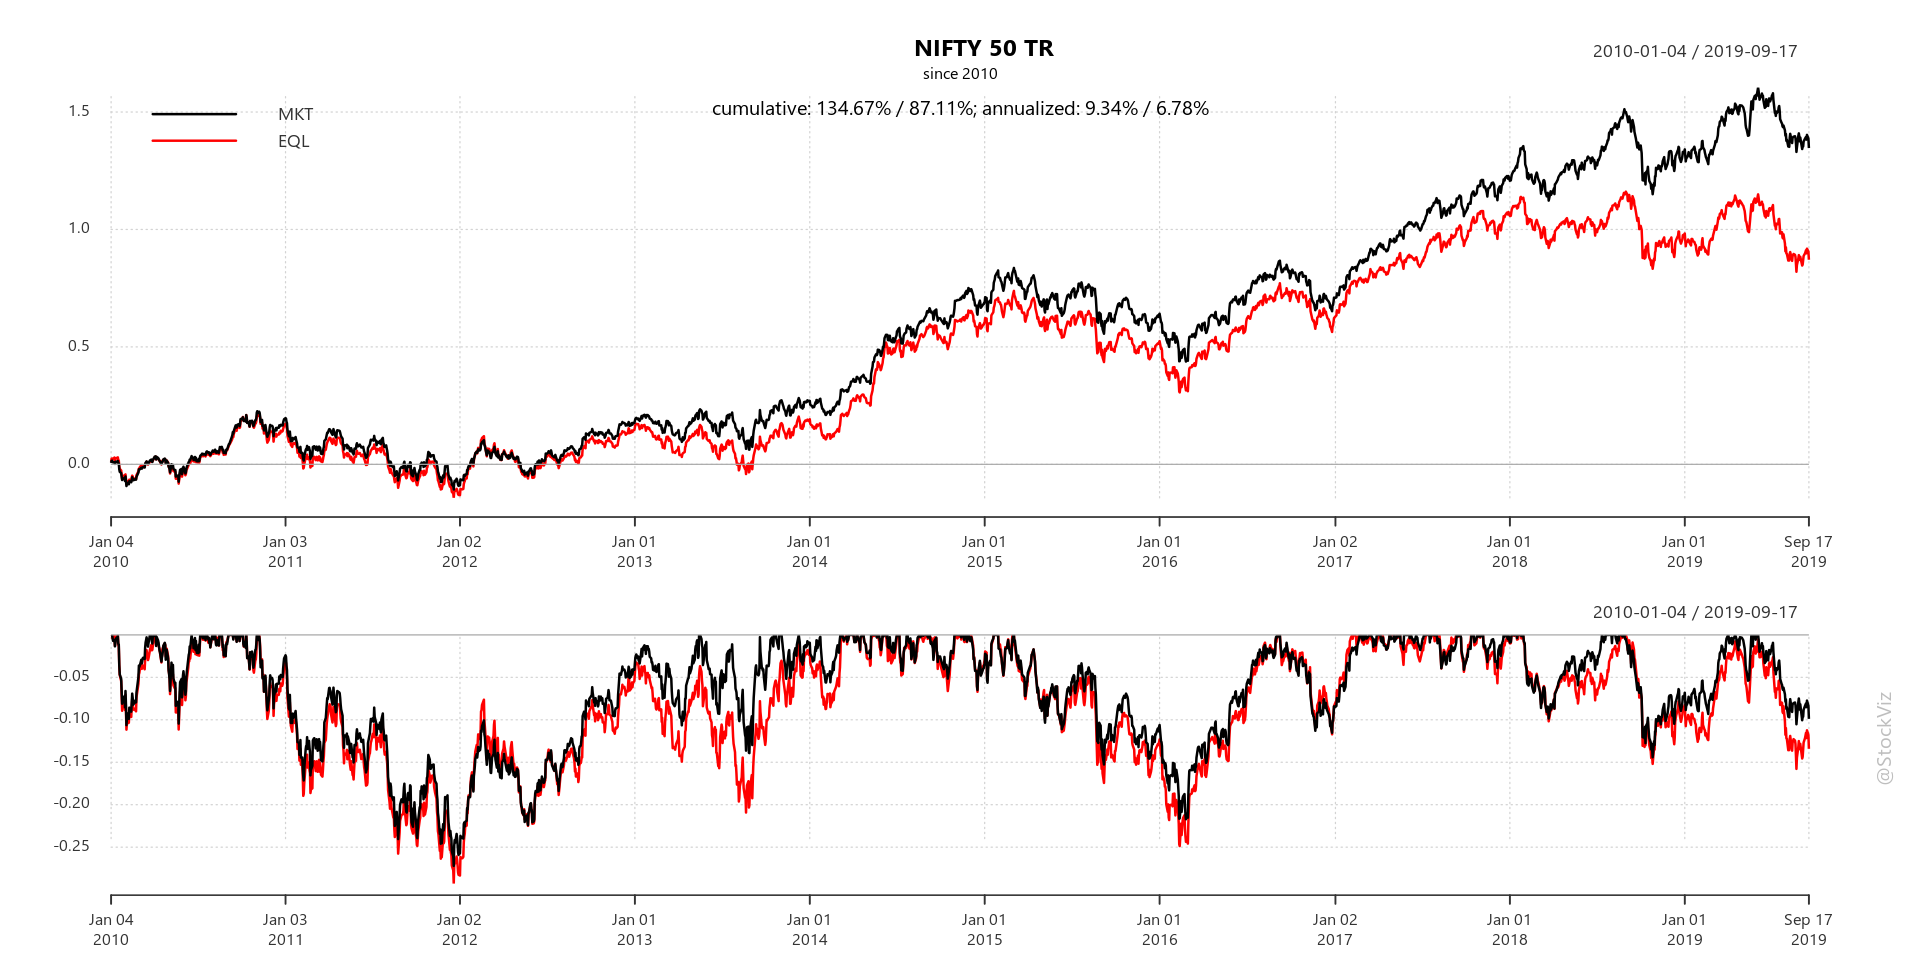

In [5]:
rets <- na.omit(merge(dailyReturn(mktcapXts), dailyReturn(eqWtXts)))
names(rets) <- c('MKT', 'EQL')
Common.PlotCumReturns(rets, "NIFTY 50 TR", "life-time")
Common.PlotCumReturns(rets["/2007"], "NIFTY 50 TR", "till 2007")
Common.PlotCumReturns(rets["2010/"], "NIFTY 50 TR", "since 2010")

Till 2007, equal-weight NIFTY out-performed market-cap weighted NIFTY by about 5%. Since 2010, however, the roles have reversed with market-cap weighted index out-performing the equal-weighted by about 3%.

The problem with the equal-weighted portfolio is the additional turnover that monthly rebalancing introduces. Investors have to pay STT on the churn. The most recent disclosures have market-cap weighted NIFTY 50 at a 10% turnover and its equal-weighted counterpart at 40%.

Given this huge difference in turnover, how should one think through market-cap weighted vs. equal weighted portfolios?

## Setup the scenarios

Here, we consider only STT (Securities Transaction Tax) and do not consider impact cost, brokerage and other fees.

In [6]:
numPeriods <- 10
totalChurn <- seq(from=0.0, to=0.90, by=0.15)
churn <- t(matrix(rep(totalChurn, numPeriods), ncol=numPeriods)) # if fund turnover is x, then churn is 2x. 
# Portfolio turnover is calculated by dividing either the total purchases or total sales, whichever is lower, by the average of the net assets. https://svz.bz/2mnc5UV 
cost <- rep(0.1, numPeriods) # STT
dates <- seq(from=as.Date("2000-01-01"), by="year", length.out=numPeriods + 1)

In [7]:
doScenarioAnalysis <- function(annualReturn){
    returns <- rep(annualReturn, numPeriods)
    scenario <- apply(churn, 2, function(ch) cumprod(1 + returns - cost*ch))
    scenario <- rbind(rep(1, ncol(churn)), scenario)
                      
    scenDf <- data.frame(scenario)
    names(scenDf) <- sapply(totalChurn, function(x) sprintf("x %.2f", x*100))
    scenDf$T <- seq(1, by=1, length.out=nrow(scenario))
    toPlot <- melt(scenDf, id='T')
                            
    ggplot(toPlot, aes(x = T, y = value, color = variable)) + 
        theme_economist() +
        geom_line() + 
        geom_text_repel(data=subset(toPlot, T == max(T)), aes(label=round(value,2)), show.legend = F) +
        geom_hline(yintercept = 1, col='grey') +
        labs(x='', y='growth of Rs. 1', fill='', color='churn(%)',
             title="Transaction cost analysis", 
             subtitle=sprintf("notional returns: %.2f%%", annualReturn*100)) +
        annotate("text", x=numPeriods, y=min(scenario, na.rm=T), label = "@StockViz", 
                 hjust=0, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)
}

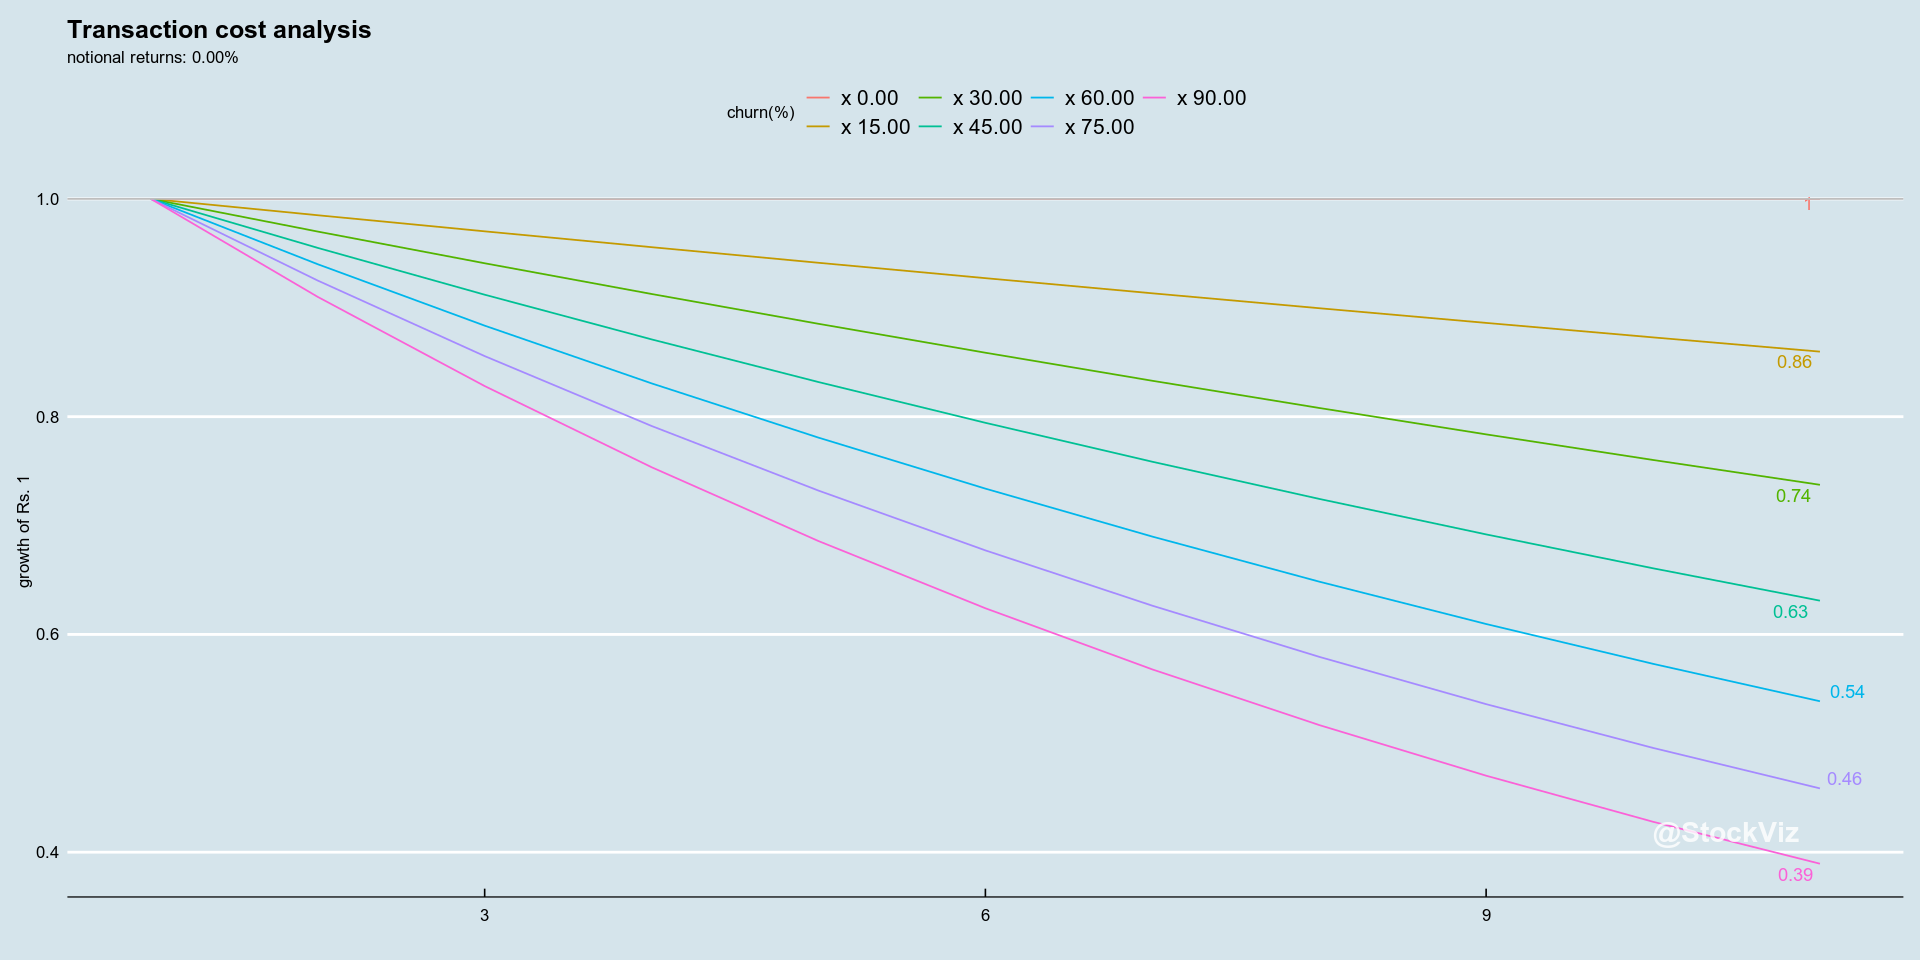

In [8]:
doScenarioAnalysis(0)

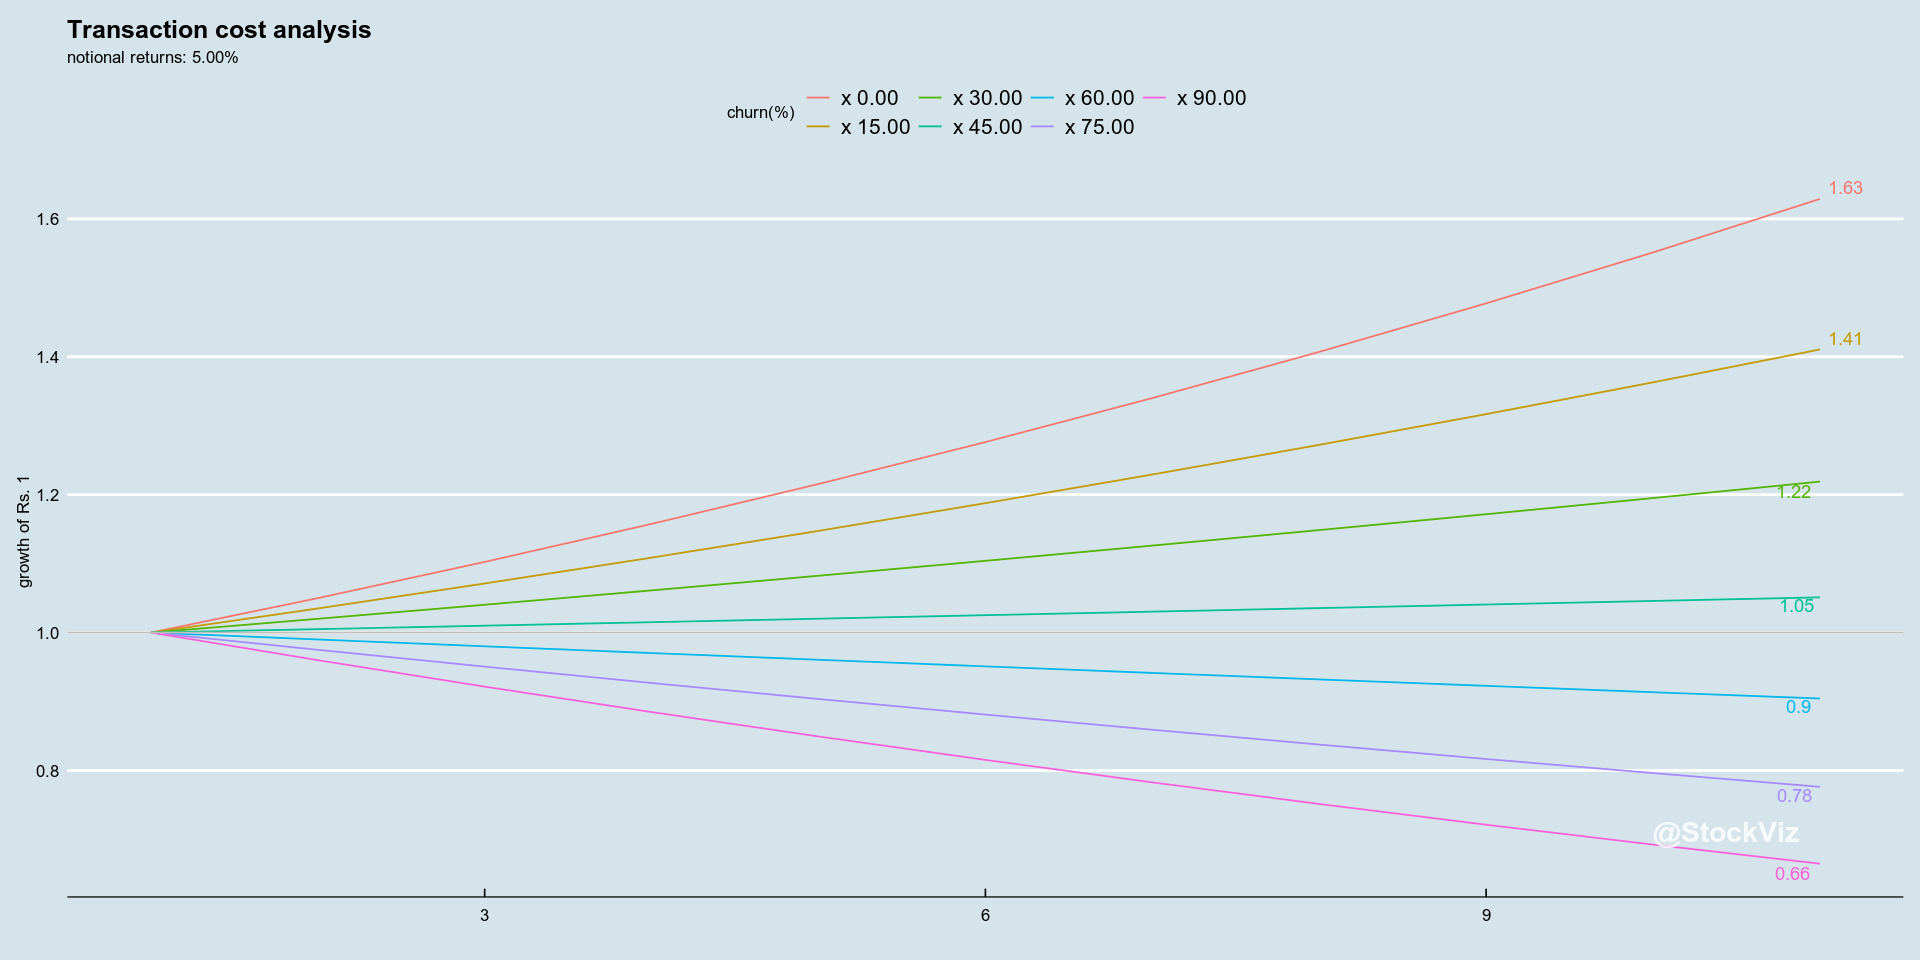

In [9]:
doScenarioAnalysis(0.05)

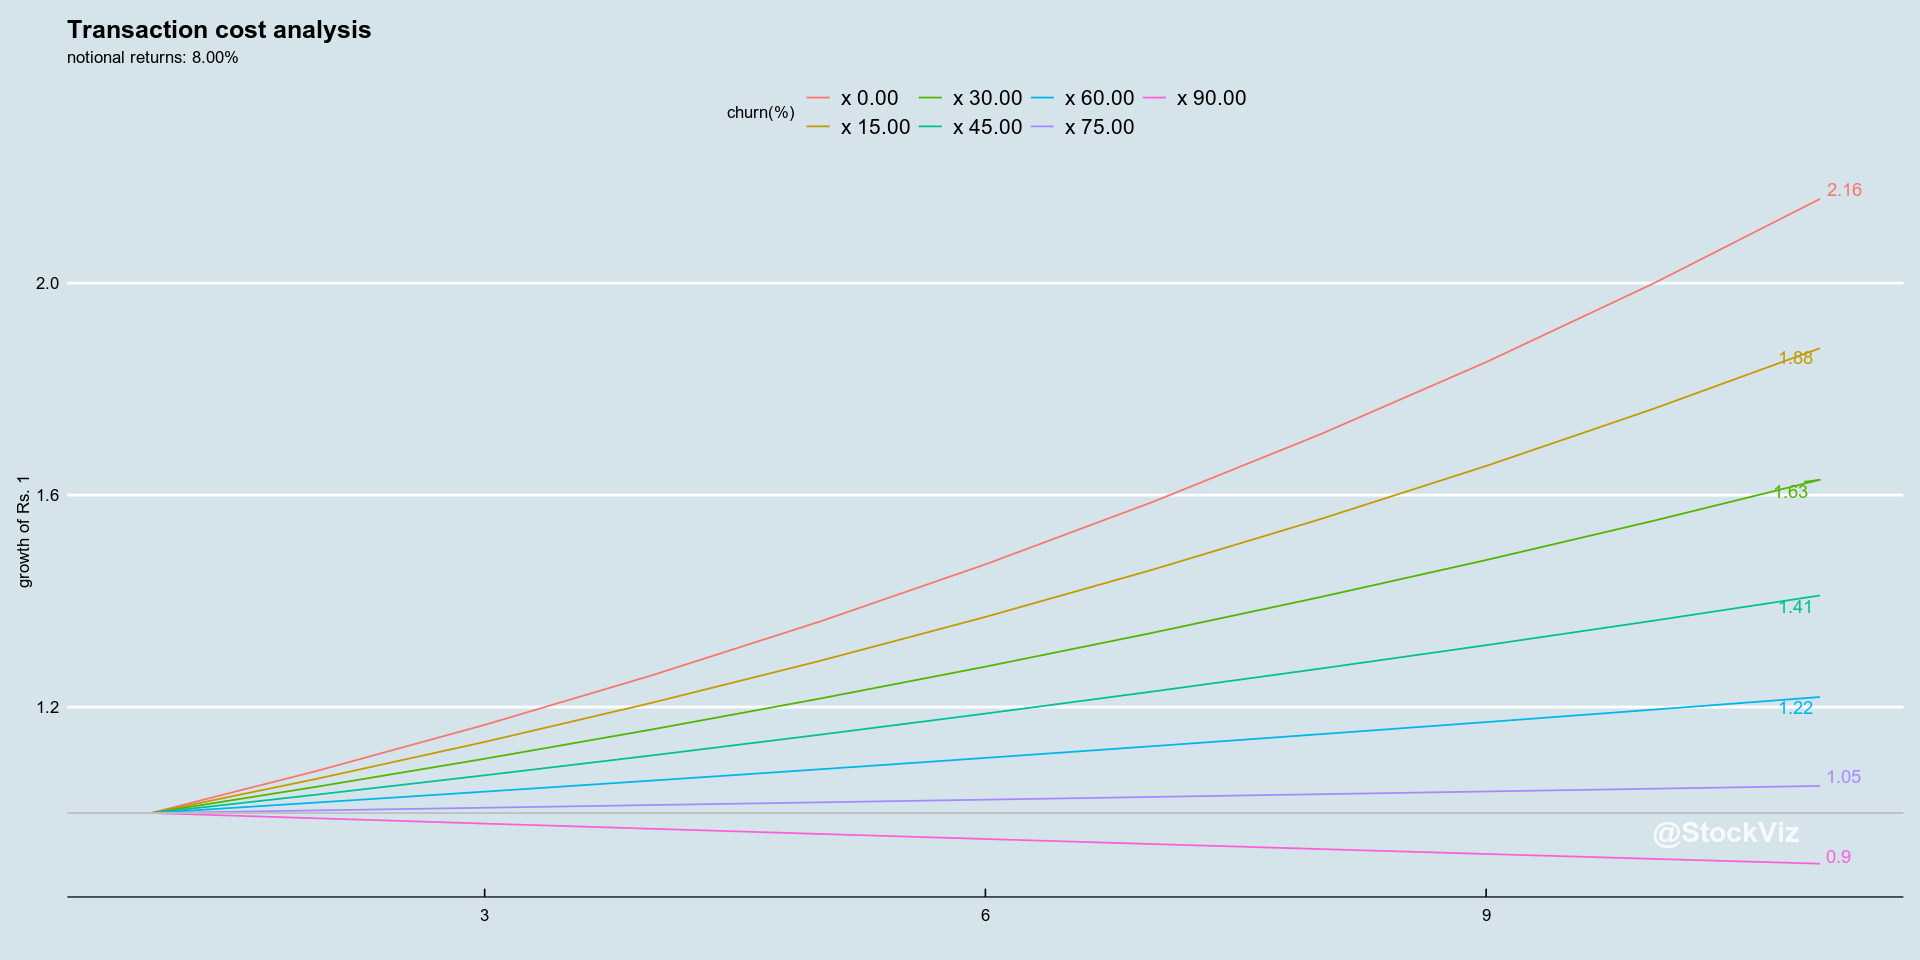

In [10]:
doScenarioAnalysis(0.08)

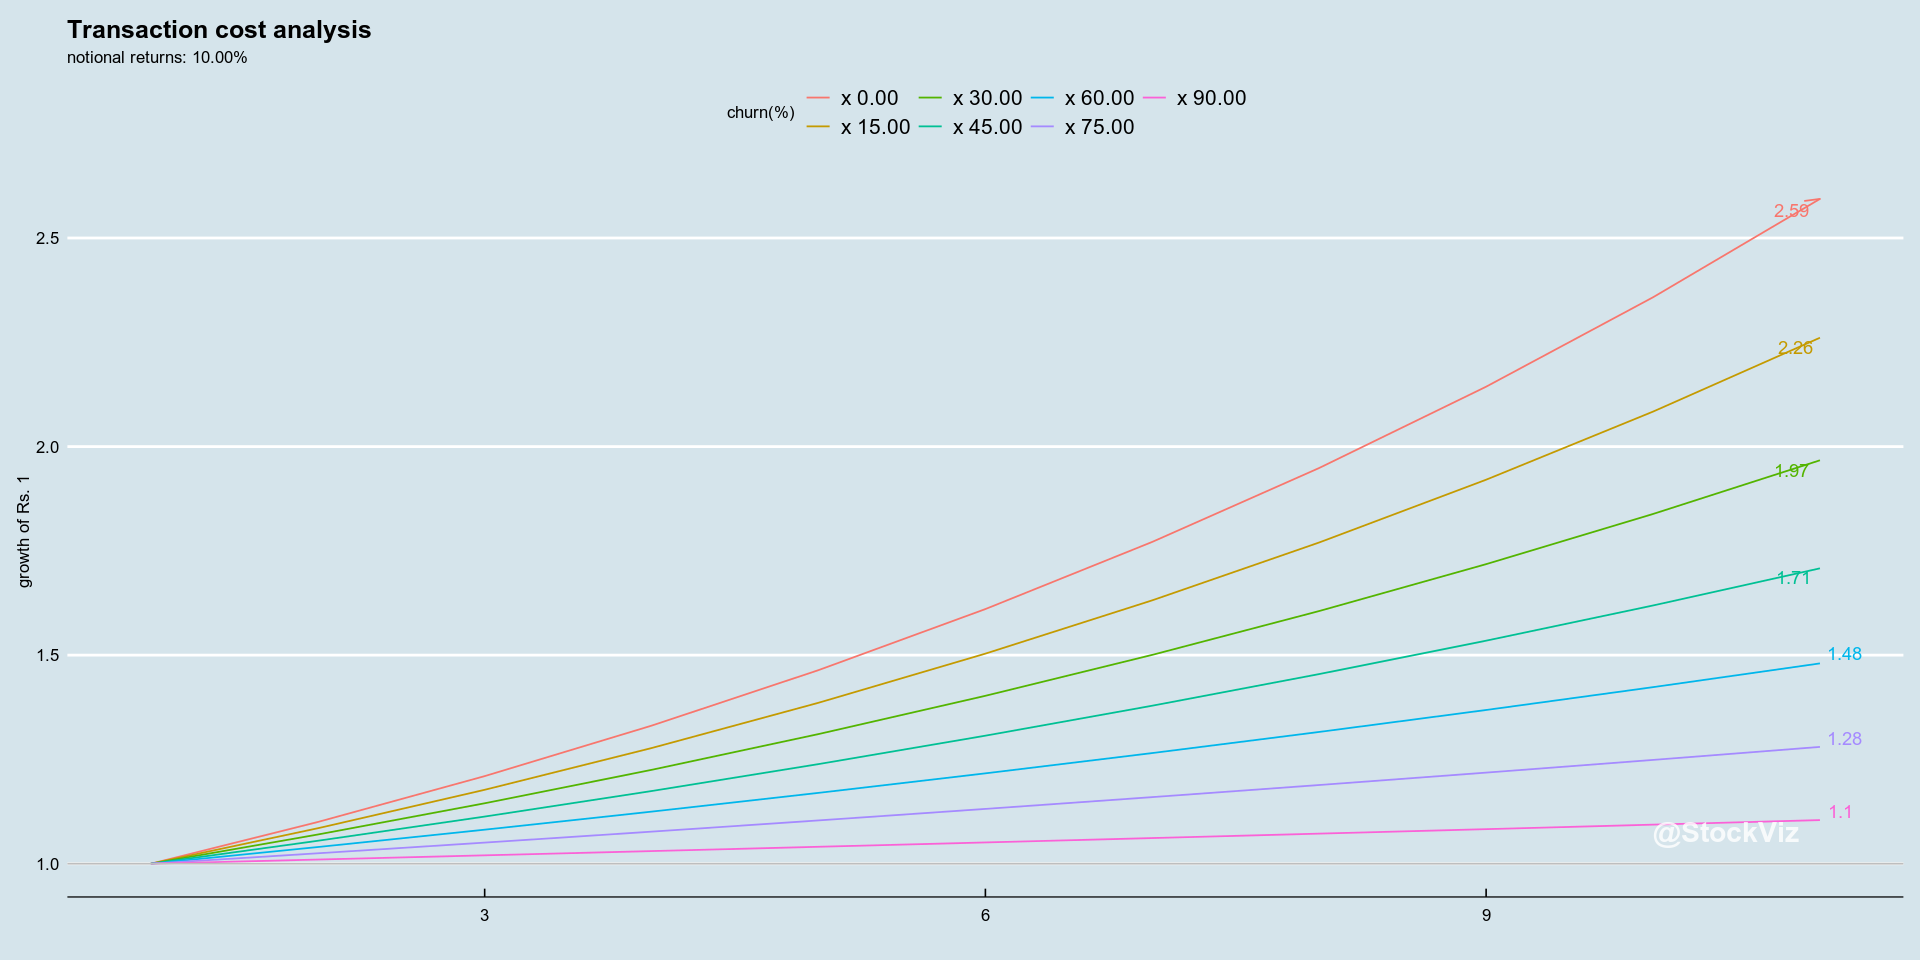

In [12]:
doScenarioAnalysis(0.1)

If you assume that 
1. 10% annual returns on the NIFTY is appropriate.
1. Notional returns of market-cap weight portfolio is equal to that of the equal weight portfolio

Then, purely because of the churn induced by rebalancing, instead of Rs. 1 growing to Rs. 2.59 in 10 years, it would have only grown to Rs. 1.28. The government pockets the difference.

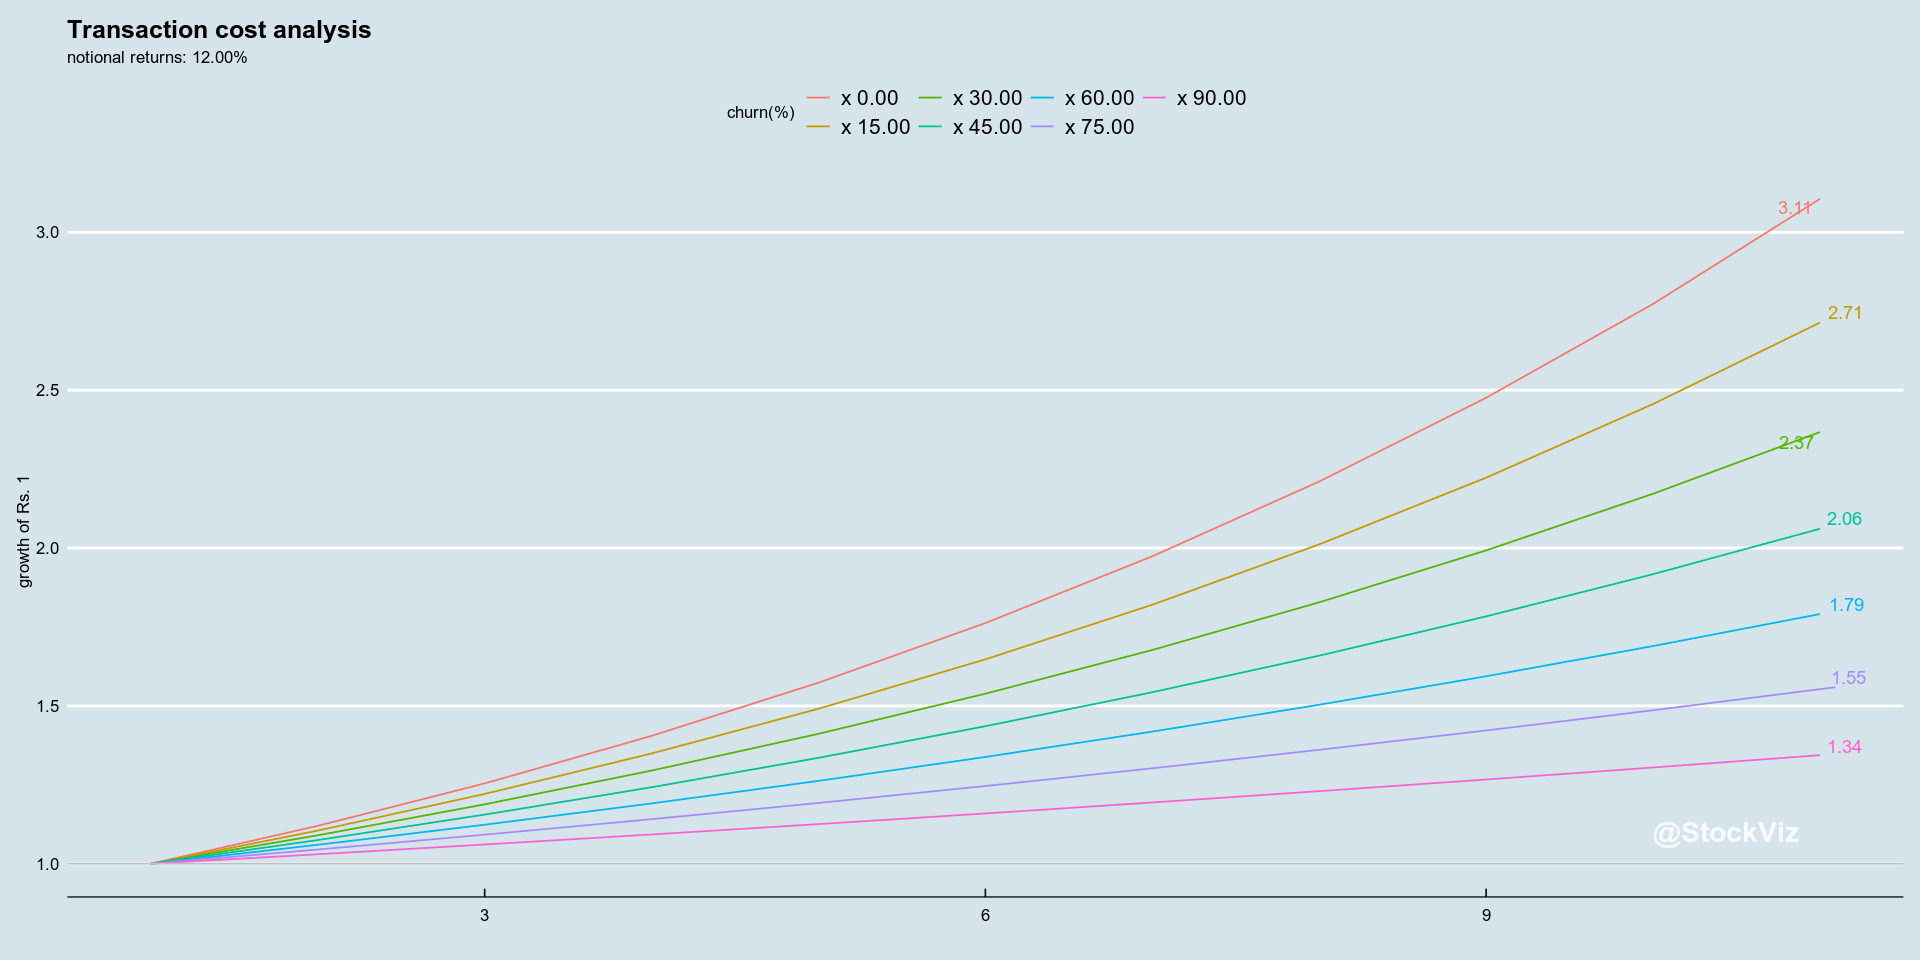

In [13]:
doScenarioAnalysis(0.12)

The final scenario shows that increasing notional returns, in itself, is not going to have a big impact on the after cost returns of the portfolio. The turnover has to be reduced as well.

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!